# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [ ]:
import os
from google.colab import drive

# Mount Google Drive at /gdrive
drive.mount('/gdrive')

# Change the current working directory to the specified path
os.chdir('/gdrive/My Drive/[2024-2025] AN2DL/Homework 1')
print(os.getcwd())

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1sSibCfy_Un23b5TdxDLKTE7IU5sAPeKD/[2024-2025] AN2DL/Homework 1


## ⚙️ Import Libraries

In [ ]:
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.utils import shuffle

import datetime
import cv2

import random

import seaborn as sns
import matplotlib.pyplot as plt

print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

mixed_precision.set_global_policy('mixed_float16')

Tensorflow version -> 2.17.0
Keras version -> 3.4.1


## ⏳ Load the Data

In [ ]:
data = np.load('training_set.npz')
X = data['images']
Y = data['labels']

# Data Cleaning

In [ ]:
# Function to plot sample images from the dataset
def plot_sample_images(X, Y, num_samples=8, col = 3):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples*col):
        plt.subplot(col, num_samples, i + 1)
        plt.imshow(X[-i])
        plt.title(f'Label: {Y[-i]}')
        plt.axis('off')
    plt.show()

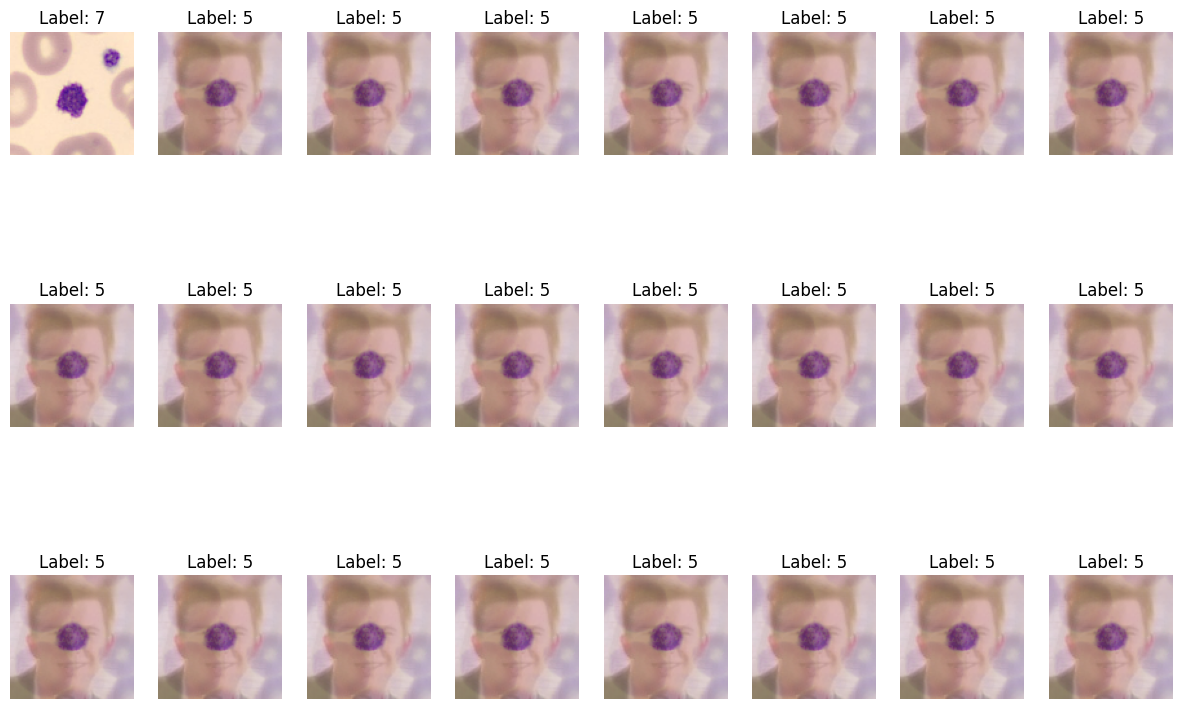

[[   0 1052]
 [   1 2381]
 [   2 1285]
 [   3 2226]
 [   4 1049]
 [   5 1393]
 [   6 2530]
 [   7 1843]]
Shape before removing meme images: (13759, 96, 96, 3)
Shape after removing meme images: (11959, 96, 96, 3)


In [ ]:
# Plot sample images from the training set
plot_sample_images(X, Y.flatten())

# Check if the dataset is balanced
unique, counts = np.unique(Y, return_counts=True)
print(np.asarray((unique, counts)).T)

# Remove meme images
print(f"Shape before removing meme images: {X.shape}")
meme_indices = range(11959, X.shape[0])
X = np.delete(X, meme_indices, axis=0)
Y = np.delete(Y, meme_indices, axis=0)
print(f"Shape after removing meme images: {X.shape}")

del unique, counts, meme_indices

# Creation of the Test Set - before Data Augmentation

I DON'T normalize the images, but keep them in the range [0, 255]. this since some augmentation techniques seem to work better in [0, 255]

In [ ]:
X_train, val_X, y_train, val_Y = train_test_split(X, Y, random_state=seed, test_size=0.30, stratify=np.argmax(Y,axis=1))

In [ ]:
del data, X, Y

# Preprocessing

#### Convex Augmentation

First, I create new samples of the same class, in a way that I balance the size of the class with most features. To do this, I interpolate the images I already have for each class.

In [ ]:
# Function to find max class size and balance dataset with blending
def balance_dataset_with_blending(data, labels, number_img_per_class = None, verbose = 0):

    # Find the maximum class size
    unique, counts = np.unique(labels, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print(f"Number of classes: {len(unique)}")
    print(f"Number of images per class: {class_counts}")
    max_class_size = 0
    if number_img_per_class is None:
        max_class_size = max(class_counts.values())
    else:
        max_class_size = number_img_per_class
    print(f"Maximum class size: {max_class_size}")

    # Initialize new dataset lists
    X_balanced = []
    Y_balanced = []

    # Loop over each class to balance
    for class_label in unique:
        # Filter images of the current class
        class_indices = np.where(labels == class_label)[0]
        class_images = data[class_indices]

        # Add original images of the class to the balanced dataset
        X_balanced.extend(class_images)
        Y_balanced.extend([class_label] * len(class_images))

        # Calculate how many more images are needed to reach max_class_size
        num_images_needed = max_class_size - len(class_images)

        # Generate blended images if the class is underrepresented
        while num_images_needed > 0:
            # Randomly pick two images to blend
            img1, img2 = random.choices(class_images, k=2)

            # Blend images with 50-50 ratio (you can vary this ratio)
            alpha = 0.2
            blended_img = cv2.addWeighted(img1, alpha, img2, 1 - alpha, 0)

            # Append the blended image to the dataset
            X_balanced.append(blended_img)
            Y_balanced.append(class_label)

            num_images_needed -= 1

    # Convert lists back to numpy arrays
    X_balanced = np.array(X_balanced)
    Y_balanced = np.array(Y_balanced)

    return X_balanced, Y_balanced


# Visualize some balanced samples
def plot_sample_images2(X, Y, start=1700, end=1720, col=5):
    num_samples = end - start
    rows = (num_samples + col - 1) // col

    plt.figure(figsize=(15, rows * 3))
    for i in range(num_samples):
        plt.subplot(rows, col, i + 1)
        plt.imshow(X[start + i])
        plt.title(f'Label: {Y[start + i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#### Random Augmentation

In [ ]:
def plot_sample_images(X, Y, num_samples=8, row = 5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples*row):
        plt.subplot(row, num_samples, i + 1)
        plt.imshow(X[-i])
        plt.title(f'Label: {Y[-i]}')
        plt.axis('off')
    plt.show()

def augment_img(img, augmentation):
    """
    Augment a single image using the specified augmentation pipeline.
    """
    augmented_img = tf.clip_by_value(augmentation(img), 0., 1.)
    return augmented_img.numpy().astype(np.float32)

def augment_data(data, labels, augmentation,  number_img = 1000):
    """
    Augment a dataset using the specified augmentation pipeline and return the augmented data concatenated with the original data.
    """
    image_to_generate = max(number_img - len(data), 0)
    data_augmented = np.zeros((image_to_generate, *data.shape[1:]), dtype=data.dtype)
    labels_augmented = np.zeros((image_to_generate, *labels.shape[1:]), dtype=labels.dtype)

    for i in range(image_to_generate):
        index = np.random.randint(0, len(data))
        data_augmented[i] = augment_img(data[index], augmentation)
        labels_augmented[i] = labels[index]

    return np.concatenate((data, data_augmented), axis=0), np.concatenate((labels, labels_augmented), axis=0)

def class_balancing(data, labels, augmentation, number_img_per_class = 10, verbose = 0):
    """
    Function to balance class distribution in the training data with augmentation
    """
    unique_classes, counts = np.unique(labels, return_counts=True)
    print(f"Number of classes: {len(unique_classes)}")
    print(f"Number of images per class: {counts}")
    number_aug = np.maximum(number_img_per_class - counts, 0)
    print(f"Number of augmented images per class: {number_aug}\n")

    data_balanced = np.zeros((number_img_per_class * len(unique_classes), *data.shape[1:]), dtype=data.dtype)
    labels_balanced = np.zeros((number_img_per_class * len(unique_classes), *labels.shape[1:]), dtype=labels.dtype)

    for i, c in enumerate(unique_classes):
        print(f"Augmenting class {c}")
        class_indices = np.where(labels == c)[0]
        class_data = data[class_indices]
        class_labels = labels[class_indices]
        augmented_data, augmented_labels = augment_data(class_data, class_labels, augmentation, number_img_per_class)

        if verbose:
            plot_sample_images(augmented_data, augmented_labels)

        start = i * number_img_per_class
        end = (i + 1) * number_img_per_class
        data_balanced[start:end] = augmented_data
        labels_balanced[start:end] = augmented_labels

    return data_balanced, labels_balanced


def display_class_distribution(xxxx, title="Class Distribution"):
    """
    Display the distribution of classes in a dataset
    """
    print(f"{title}:")
    unique, counts = np.unique(xxxx, return_counts=True)
    print(np.asarray((unique, counts)).T)



#### Data Augmentation Pipeline

In [ ]:
def augmentation_pipeline(X_train, y_train, balanced = True, random_augmentation = False, number = 3000):
    """
    Function to create the augmentation pipeline.
    Parameters:
    - X_train: training images
    - y_train: training labels
    - balanced: whether to balance the dataset with convex augmentation
    - random_augmentation: whether to apply random augmentation
    - number: number of augmented images per class
    """
    if balanced :
        # Balance the dataset
        if not random_augmentation:
            X_balanced, Y_balanced = balance_dataset_with_blending(X_train, y_train.flatten(), number_img_per_class = number)
        else:
            X_balanced, Y_balanced = balance_dataset_with_blending(X_train, y_train.flatten())
        # Add a channel dimension
        Y_balanced= np.expand_dims(Y_balanced, axis = 1)

        # Verify new class distribution
        unique_balanced, counts_balanced = np.unique(Y_balanced, return_counts=True)
        print("Balanced Class Distribution:", np.asarray((unique_balanced, counts_balanced)).T)

        # Plot sample images from the balanced dataset
        plot_sample_images2(X_balanced, Y_balanced)

        X_train, y_train = X_balanced, Y_balanced
        del X_balanced, Y_balanced

    if random_augmentation:
        augmentation = tfk.Sequential([
            tfkl.RandomFlip("horizontal_and_vertical"),
            tfkl.RandomRotation(1), # 1 set it all 360°, value range is of the pixels
            tfkl.RandomBrightness(0.5, value_range=(0,1)),
            tfkl.RandomContrast(0.8),
        ], name='Augmentation')

        # Normalize the input
        X_train = X_train/255
        X_augmented, y_augmented = class_balancing(X_train, y_train, augmentation, number, verbose = 1)
        display_class_distribution(y_augmented, "Augmented Class Distribution")

        X_train, y_train = X_augmented, y_augmented
        del X_augmented, y_augmented

    return X_train, y_train

Number of classes: 8
Number of images per class: {0: 585, 1: 1537, 2: 765, 3: 1409, 4: 583, 5: 705, 6: 1638, 7: 1149}
Maximum class size: 10000
Balanced Class Distribution: [[    0 10000]
 [    1 10000]
 [    2 10000]
 [    3 10000]
 [    4 10000]
 [    5 10000]
 [    6 10000]
 [    7 10000]]


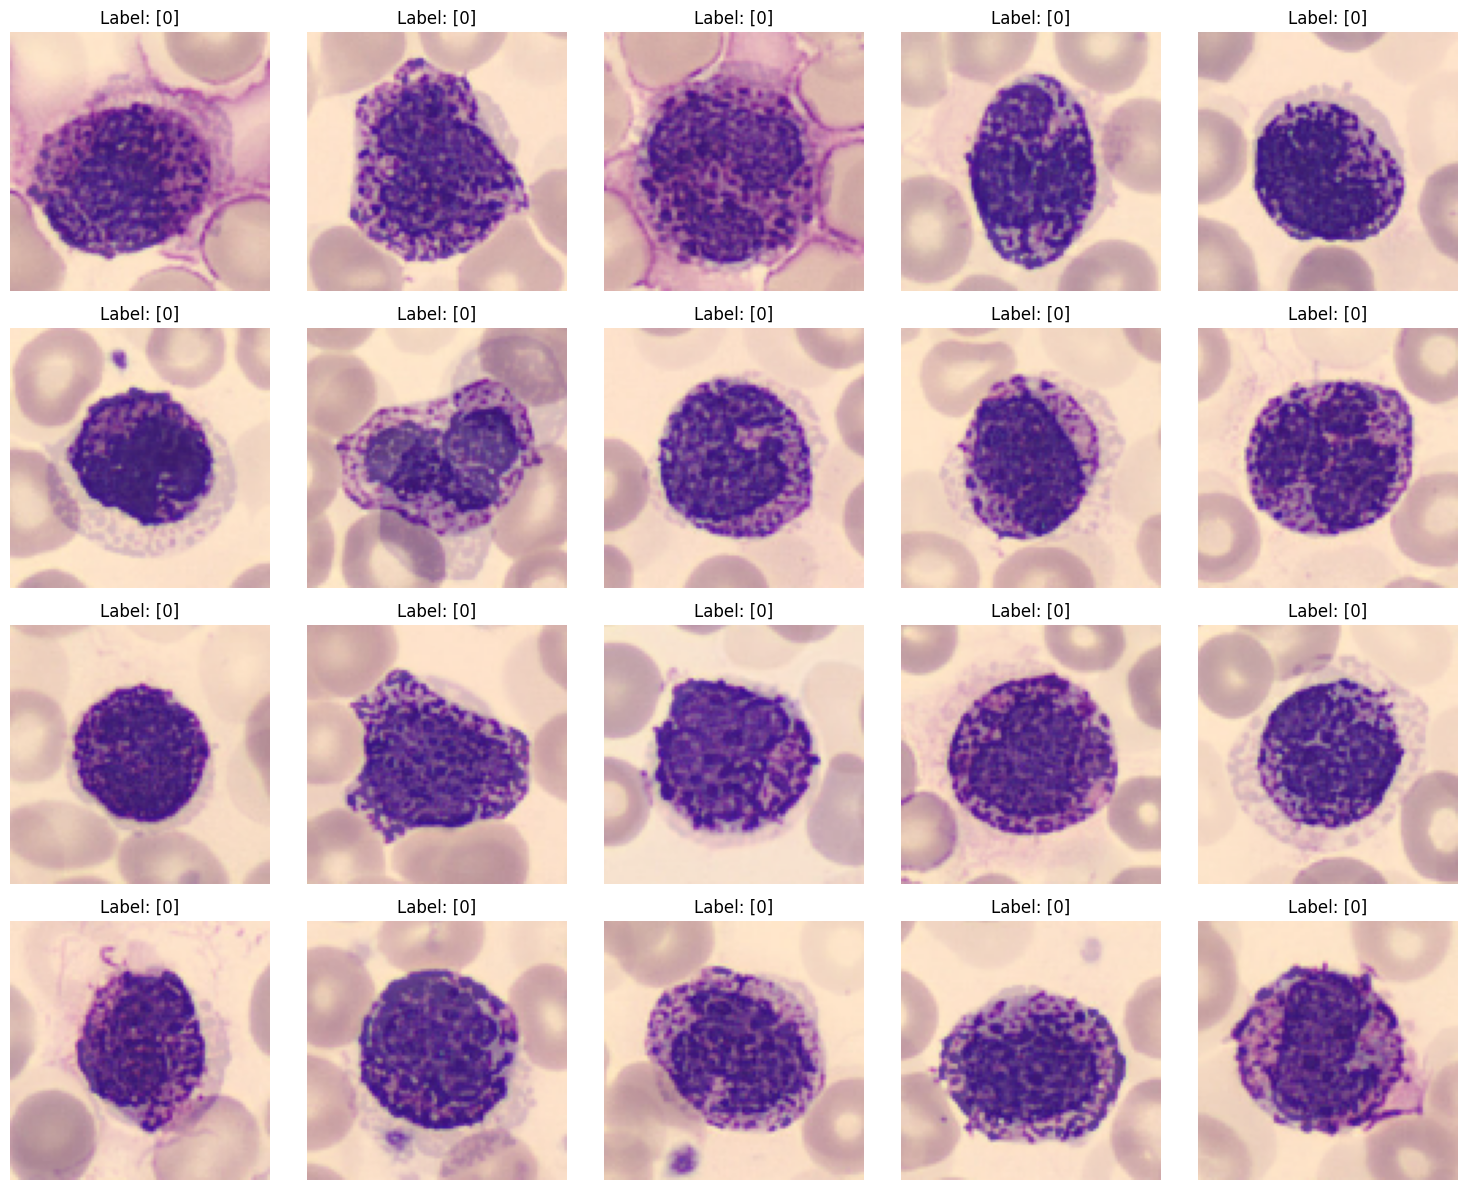

In [ ]:
X_train, y_train = augmentation_pipeline(X_train, y_train, balanced = True, random_augmentation = False, number = 10000)

# One-hot encode the labels of the training
y_train = tfk.utils.to_categorical(y_train)
val_Y = tfk.utils.to_categorical(val_Y)

# Transfer learning using EfficientNetB4

## Model parameters

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]


pretrained_net = tfk.applications.EfficientNetB0(input_shape=input_shape, weights="imagenet", include_top= False,
                                         pooling=None)

# Display a summary of the model architecture
pretrained_net.summary(expand_nested=True)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 96, 96, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 96, 96, 3)      │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 96, 96, 3)      │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 97, 97, 3)      │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 48, 48, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 48, 48, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 48, 48, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 48, 48, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 48, 48, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 48, 48, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

## Model Creation

In [ ]:
def create_model(input_shape, output_shape, pretrained_net, learning_rate, augmentation_layer = None):
    """
    Function to create the model architecture
    """
    # Freeze all layers in effnet to use it solely as a feature extractor
    pretrained_net.trainable = False

    # Define the input layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    # Apply the augmentation layer if provided
    if augmentation_layer is not None:
        x = augmentation_layer(inputs)
    else:
        x = inputs

    # same as clip the output of augmentation
    x = tfkl.BatchNormalization()(x)

    # Pass augmented inputs through the effnet feature extractor
    x = pretrained_net(x)

    # Add a dropout layer for regularisation
    x = tfkl.Dropout(0.3, name='dropout')(x)

    # Apply global average pooling to reduce spatial dimensions
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    # Add a dense layer for final output processing
    x = tfkl.Dense(output_shape, name='dense')(x)

    # Apply softmax activation for output layer
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Define the complete model linking input and output
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Compile the model
    optimizer = tfk.optimizers.Lion()
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

    # Display model summary and plot architecture
    model.summary(expand_nested=True, show_trainable=True)

    return model


## 🛠️ Train and Save the Model

In [ ]:
# Normalize Validation Set
val_X = val_X/255

In [ ]:
epochs = 400
batch_size = 256

augmentation = tfk.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomRotation(1), # 1 set it all 360°, value range is of the pixels
    tfkl.RandomBrightness(0.5, value_range=(0,1)),
    tfkl.RandomContrast(0.8),
], name='Augmentation')

model = create_model(input_shape, output_shape, pretrained_net, learning_rate = 1e-2,augmentation_layer=augmentation)

# Define callbacks
callbacks = [
    tfk.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=epochs*0.1,
        restore_best_weights=True
    ),
]

checkpoint_folder = 'checkpoints'
def setup_checkpoint_folders(start_time, callbacks, checkpoint_folder):
    # Add ModelCheckpoint callback for this fold
    if not os.path.exists(checkpoint_folder):
        os.makedirs(checkpoint_folder)

    starting_time_folder = f'{start_time}'
    checkpoint_folder = f'{checkpoint_folder}/{starting_time_folder}'
    if not os.path.exists(checkpoint_folder):
        os.makedirs(checkpoint_folder)
    checkpoint_path = f'{checkpoint_folder}/best_model.keras'

    checkpoint = tfk.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Add the checkpoint callback to the list of callbacks
    callbacks.append(checkpoint)

    return callbacks


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ Augmentation (Sequential)           │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip (RandomFlip)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_rotation                │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomRotation)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_brightness              │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomBrightness)                  │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_contrast                │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomContrast)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization                 │ (None, 96, 96, 3)            │            12 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficientnetb0 (Functional)         │ (None, 3, 3, 1280)           │     4,049,571 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ input_layer (InputLayer)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ rescaling (Rescaling)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ normalization (Normalization)  │ (None, 96, 96, 3)            │             7 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ rescaling_1 (Rescaling)        │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_conv_pad (ZeroPadding2D)  │ (None, 97, 97, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_conv (Conv2D)             │ (None, 48, 48, 32)           │           864 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_bn (BatchNormalization)   │ (None, 48, 48, 32)           │           128 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_activation (Activation)   │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_dwconv                 │ (None, 48, 48, 32)           │           288 │    N    │
│ (DepthwiseConv2D)                   │                              │               │         │
├──────────────────────

 Total params: 4,059,831 (15.49 MB)

 Trainable params: 10,254 (40.05 KB)

 Non-trainable params: 4,049,577 (15.45 MB)

In [ ]:
start_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

callbacks = setup_checkpoint_folders(start_time, callbacks, checkpoint_folder)

print(f'Starting training at {start_time}')

# Train the model
pretrained_model_history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_X, val_Y),
    callbacks=callbacks
).history

# Calculate and print the best validation accuracy achieved
initial_val_accuracy = round(max(pretrained_model_history['val_accuracy']) * 100, 2)
print(f'Initial validation accuracy: {initial_val_accuracy}%')

# move best weight of this train into weights.keras
temp = f"checkpoints/{start_time}"
best_model_path = os.path.join(temp, 'best_model.keras')
destination_path = './weights.keras'

!mv "{best_model_path}" "{destination_path}"

# Free memory by deleting the model instance
del model

Starting training at 2024-11-14 13:53:34
Epoch 1/400
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.1258 - loss: 2.0998
Epoch 1: val_accuracy improved from -inf to 0.19314, saving model to checkpoints/2024-11-14 13:53:34/best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 93s 223ms/step - accuracy: 0.1258 - loss: 2.0998 - val_accuracy: 0.1931 - val_loss: 2.0797
Epoch 2/400
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.1262 - loss: 2.1047
Epoch 2: val_accuracy did not improve from 0.19314
313/313 ━━━━━━━━━━━━━━━━━━━━ 66s 208ms/step - accuracy: 0.1262 - loss: 2.1047 - val_accuracy: 0.0942 - val_loss: 2.2264
Epoch 3/400
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.1267 - loss: 2.1054
Epoch 3: val_accuracy did not improve from 0.19314
313/313 ━━━━━━━━━━━━━━━━━━━━ 65s 206ms/step - accuracy: 0.1267 - loss: 2.1054 - val_accuracy: 0.1201 - val_loss: 2.1108
Epoch 4/400
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.1240 - loss: 2.1063
Epoch 4: val_accuracy d

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')
        self.neural_network.trainable = False
        #self.neural_network.summary()

    def data_preprocessing(self, data):
        """
        Preprocessing function
        """
        data = (data / 255).astype('float32')

        return np.array(data)

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        temp = X.copy()
        temp = self.data_preprocessing(temp)

        preds = self.neural_network.predict(temp)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
from model import Model

temp = Model()

test_test = test_X
test_predictions = temp.predict(test_test)
print(f"Results: {test_predictions}")
print(f"Expected: {test_gt}")

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

val_test = val_X
val_predictions = temp.predict(val_test)
print(f"Results: {val_predictions}")
print(f"Expected: {np.argmax(val_Y, axis = -1)}")
test_accuracy = accuracy_score(np.argmax(val_Y, axis = -1), val_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')



In [ ]:
from datetime import datetime

sub_folder = "submission"
if not os.path.exists(sub_folder):
    os.makedirs(sub_folder)
filename = f'{sub_folder}/submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 58%)
  adding: weights.keras (deflated 12%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>